In [40]:
# This notebook contains a naive mlp for garbage classification
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import utils
from vocab import Vocabulary
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
use_cuda = True
device = torch.device("cuda:0" if use_cuda else "cpu") 
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import os
EMB_DIM = 100 # embedding dimension to be used, choose from [50, 100, 200, 300]
glove_path = os.path.expanduser('./glove.6B.{}d.txt'.format(EMB_DIM))
embedding_dict = utils.load_glove_to_dict(glove_path)

400000it [00:09, 42596.09it/s]


In [42]:
MAX_SEQ_LEN = 10 # The maximum input sequence length, if longer, truncate; if shorter, pad

complete_csv_path = './preprocessed.csv'
complete_df = pd.read_csv(complete_csv_path)

complete_vocab = utils.build_vocab(complete_df)

wvecs = utils.build_wvecs(embedding_dict, complete_vocab)

train_csv_path = './train.csv'
val_csv_path = './val.csv'
test_csv_path = './test.csv'

In [43]:
# Load dataset
train_dataset = utils.GarbageDataset(train_csv_path, complete_vocab, MAX_SEQ_LEN)
val_dataset = utils.GarbageDataset(val_csv_path, complete_vocab, MAX_SEQ_LEN)
test_dataset = utils.GarbageDataset(test_csv_path, complete_vocab, MAX_SEQ_LEN)

# Construct dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=utils.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=utils.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=utils.collate_fn)

In [44]:
class CNN(nn.Module):
    # Baseline mlp for garbage classification
    def __init__(self, embedding_dim, vocab_size, max_seq_length):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.max_seq_length = max_seq_length
        self.embedding_dim = embedding_dim
        self.conv1 = nn.Conv2d(1,16,(3,5))
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,(3,9))
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(32*20,128)
        self.fc2 = nn.Linear(128,32)
        self.out = nn.Linear(32, 4)

    def forward(self, sequence):
        batch_size = sequence.shape[0]
        embedded = self.embedding(sequence)
        # print(embedded.shape)
        embedded = embedded.view(batch_size, 1, self.max_seq_length, self.embedding_dim) # reshape the text as a pic like
        # print(embedded.shape)
        z = F.relu(self.conv1(embedded))
        # print(z.shape)
        z = self.pool1(z)
        # print(z.shape)
        z = F.relu(self.conv2(z))
        # print(z.shape)
        z = self.pool2(z)
        # print(z.shape)
        z = z.view(batch_size, -1)
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = F.relu(self.out(z))
        return z

In [45]:
def eval(loader: DataLoader, model):
    """Evaluate the classification accuracy of model on the given dataset

    Args:
        loader (DataLoader): 
        model ([type])
    """
    correct_counts = 0
    loss_sum = 0
    with torch.no_grad():
        for batch in loader:
            input, target = batch
            input, target = input.to(device), target.to(device)
            pred = model(input).squeeze(1)
            pred_classes = torch.argmax(pred, dim=1)
            correct_counts += torch.sum(pred_classes == target)
            loss = loss_fn(pred, target.long())
            loss_sum += loss.item() * target.shape[0]
    # print(correct_counts.item() / len(loader.dataset))
    return correct_counts.item() / len(loader.dataset), loss_sum / len(loader.dataset)

In [46]:
def eval_classes(loader: DataLoader, model):
    """Evaluate the classification accuracy of model on the given dataset

    Args:
        loader (DataLoader): 
        model ([type])
    """
    correct_counts = [0] * 4
    class_counts = [0] * 4
    with torch.no_grad():
        for batch in loader:
            input, target = batch
            input, target = input.to(device), target.to(device)
            pred = model(input).squeeze(1)
            pred_classes = torch.argmax(pred, dim=1)
            for i in range(4):
                i_class_index = torch.where(target == i)[0]
                if len(i_class_index) != 0:
                    correct_counts[i] += torch.sum(pred_classes[i_class_index] == target[i_class_index])
                    class_counts[i] += len(i_class_index)
    # print(correct_counts.item() / len(loader.dataset))
    # print(correct_counts, class_counts)
    return [x/y for x,y in zip(correct_counts, class_counts)], class_counts

In [47]:
use_glove = False

net = CNN(100, len(complete_vocab), MAX_SEQ_LEN).to(device)
if use_glove:   
    net.embedding.weight.data.copy_(torch.from_numpy(np.array(wvecs)))
max_epoch = 100

optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

train_acc_stats = []
val_acc_stats = []
test_acc_stats = []
train_loss_stats = []
val_loss_stats = []
test_loss_stats = []
best_test_acc = 0
print('Start training')
for epoch in range(max_epoch):
    net.train()
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input, target = batch
        input, target = input.to(device), target.to(device)
        # print(input.shape)
        pred = net(input).squeeze(1)
        loss = loss_fn(pred, target.long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * target.shape[0]
    net.eval()
    val_acc, val_loss = eval(val_loader, net)
    train_acc, train_loss = eval(train_loader, net)
    test_acc, test_loss = eval(test_loader, net)
    val_acc_stats.append(val_acc)
    val_loss_stats.append(val_loss)
    train_acc_stats.append(train_acc)
    train_loss_stats.append(train_loss)
    test_acc_stats.append(test_acc)
    test_loss_stats.append(test_loss)
    if test_acc > best_test_acc:
        best_test_acc = test_acc
    print('Epoch:{}\tTrain Loss:{:4f}\tTrain Acc:{:4f}\tVal Loss:{:4f}\tVal Acc:{:4f}\tTest Loss:{:4f}\tTest Acc:{:4f}\tBest Test Acc:{:4f}'.format(
        epoch+1, train_loss, train_acc, val_loss, val_acc,test_loss,test_acc,best_test_acc))


Start training
Epoch:1	Train Loss:1.313321	Train Acc:0.356420	Val Loss:1.296231	Val Acc:0.358779	Test Loss:1.314908	Test Acc:0.387909	Best Test Acc:0.387909
Epoch:2	Train Loss:1.309270	Train Acc:0.356420	Val Loss:1.294398	Val Acc:0.358779	Test Loss:1.310962	Test Acc:0.387909	Best Test Acc:0.387909
Epoch:3	Train Loss:1.296384	Train Acc:0.356420	Val Loss:1.285762	Val Acc:0.358779	Test Loss:1.300932	Test Acc:0.387909	Best Test Acc:0.387909
Epoch:4	Train Loss:1.251903	Train Acc:0.373182	Val Loss:1.258449	Val Acc:0.376590	Test Loss:1.268155	Test Acc:0.400504	Best Test Acc:0.400504
Epoch:5	Train Loss:1.176425	Train Acc:0.432321	Val Loss:1.216952	Val Acc:0.386768	Test Loss:1.228189	Test Acc:0.385390	Best Test Acc:0.400504
Epoch:6	Train Loss:0.993426	Train Acc:0.576534	Val Loss:1.088083	Val Acc:0.503817	Test Loss:1.067401	Test Acc:0.528967	Best Test Acc:0.528967
Epoch:7	Train Loss:0.879088	Train Acc:0.648008	Val Loss:1.037722	Val Acc:0.544529	Test Loss:1.016641	Test Acc:0.549118	Best Test Acc:

In [48]:
net.eval()
test_acc, test_loss = eval(test_loader, net)
print('Test Acc:{}'.format(test_acc))

Test Acc:0.6675062972292192


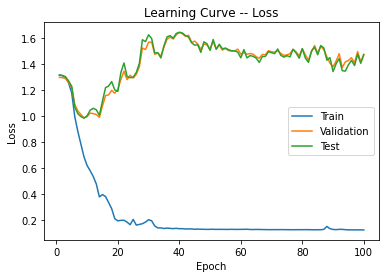

In [49]:
import matplotlib.pyplot as plt
plt.figure()
E = np.arange(1, max_epoch+1,1)
plt.title('Learning Curve -- Loss')
plt.plot(E, train_loss_stats, label='Train')
plt.plot(E, val_loss_stats, label='Validation')
plt.plot(E, test_loss_stats, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

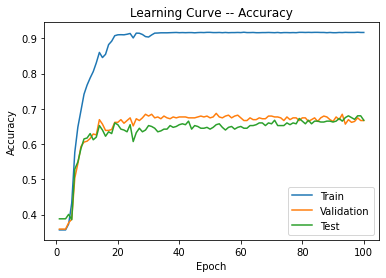

In [50]:
import matplotlib.pyplot as plt
plt.figure()
E = np.arange(1, max_epoch+1,1)
plt.title('Learning Curve -- Accuracy')
plt.plot(E, train_acc_stats, label='Train')
plt.plot(E, val_acc_stats, label='Validation')
plt.plot(E, test_acc_stats, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [51]:
class_train_acc, class_train_count = eval_classes(train_loader, net)
print('Accuracy of each class on Training set. hazardous wast:{:4f}\trecyclable waste:{:4f}\thousehold food waste:{:4f}\tresidual waste:{:4f}'.format(class_train_acc[0],class_train_acc[1],class_train_acc[2],class_train_acc[3]))
print('Amount of each class on Training set. hazardous wast:{}\trecyclable waste:{}\thousehold food waste:{}\tresidual waste:{}'.format(class_train_count[0],class_train_count[1],class_train_count[2],class_train_count[3]))
class_test_acc, class_test_count = eval_classes(test_loader, net)
print('Accuracy of each class on Test set. hazardous wast:{:4f}\trecyclable waste:{:4f}\thousehold food waste:{:4f}\tresidual waste:{:4f}'.format(class_test_acc[0],class_train_acc[1],class_test_acc[2],class_test_acc[3]))
print('Amount of each class on Test set. hazardous wast:{}\trecyclable waste:{}\thousehold food waste:{}\tresidual waste:{}'.format(class_test_count[0],class_test_count[1],class_test_count[2],class_test_count[3]))

Accuracy of each class on Training set. hazardous wast:0.982353	recyclable waste:0.000000	household food waste:0.990184	residual waste:0.966282
Amount of each class on Training set. hazardous wast:1020	recyclable waste:200	household food waste:815	residual waste:1127
Accuracy of each class on Test set. hazardous wast:0.681818	recyclable waste:0.000000	household food waste:0.701754	residual waste:0.714286
Amount of each class on Test set. hazardous wast:110	recyclable waste:19	household food waste:114	residual waste:154


In [52]:
use_glove = True

net = CNN(100, len(complete_vocab), MAX_SEQ_LEN).to(device)
if use_glove:   
    net.embedding.weight.data.copy_(torch.from_numpy(np.array(wvecs)))
max_epoch = 100

optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

train_acc_stats = []
val_acc_stats = []
test_acc_stats = []
train_loss_stats = []
val_loss_stats = []
test_loss_stats = []
best_test_acc = 0
print('Start training')
for epoch in range(max_epoch):
    net.train()
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input, target = batch
        input, target = input.to(device), target.to(device)
        # print(input.shape)
        pred = net(input).squeeze(1)
        loss = loss_fn(pred, target.long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * target.shape[0]
    net.eval()
    val_acc, val_loss = eval(val_loader, net)
    train_acc, train_loss = eval(train_loader, net)
    test_acc, test_loss = eval(test_loader, net)
    val_acc_stats.append(val_acc)
    val_loss_stats.append(val_loss)
    train_acc_stats.append(train_acc)
    train_loss_stats.append(train_loss)
    test_acc_stats.append(test_acc)
    test_loss_stats.append(test_loss)
    if test_acc > best_test_acc:
        best_test_acc = test_acc
    print('Epoch:{}\tTrain Loss:{:4f}\tTrain Acc:{:4f}\tVal Loss:{:4f}\tVal Acc:{:4f}\tTest Loss:{:4f}\tTest Acc:{:4f}\tBest Test Acc:{:4f}'.format(
        epoch+1, train_loss, train_acc, val_loss, val_acc,test_loss,test_acc,best_test_acc))


Start training
Epoch:1	Train Loss:1.255441	Train Acc:0.356420	Val Loss:1.215336	Val Acc:0.358779	Test Loss:1.233426	Test Acc:0.387909	Best Test Acc:0.387909
Epoch:2	Train Loss:1.253434	Train Acc:0.356420	Val Loss:1.214440	Val Acc:0.358779	Test Loss:1.230260	Test Acc:0.387909	Best Test Acc:0.387909
Epoch:3	Train Loss:1.248704	Train Acc:0.356420	Val Loss:1.211929	Val Acc:0.358779	Test Loss:1.226118	Test Acc:0.387909	Best Test Acc:0.387909
Epoch:4	Train Loss:1.234615	Train Acc:0.356420	Val Loss:1.200078	Val Acc:0.358779	Test Loss:1.213533	Test Acc:0.387909	Best Test Acc:0.387909
Epoch:5	Train Loss:1.182334	Train Acc:0.380772	Val Loss:1.165836	Val Acc:0.389313	Test Loss:1.167364	Test Acc:0.380353	Best Test Acc:0.387909
Epoch:6	Train Loss:1.023980	Train Acc:0.585705	Val Loss:1.051750	Val Acc:0.524173	Test Loss:1.052555	Test Acc:0.574307	Best Test Acc:0.574307
Epoch:7	Train Loss:0.846595	Train Acc:0.680582	Val Loss:0.949090	Val Acc:0.618321	Test Loss:0.928578	Test Acc:0.627204	Best Test Acc:

In [53]:
net.eval()
test_acc, test_loss = eval(test_loader, net)
print('Test Acc:{}'.format(test_acc))

Test Acc:0.6775818639798489


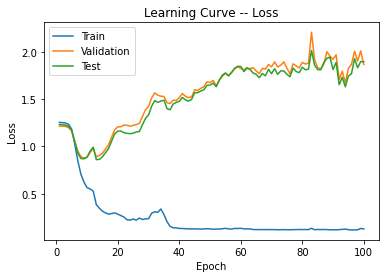

In [54]:
import matplotlib.pyplot as plt
plt.figure()
E = np.arange(1, max_epoch+1,1)
plt.title('Learning Curve -- Loss')
plt.plot(E, train_loss_stats, label='Train')
plt.plot(E, val_loss_stats, label='Validation')
plt.plot(E, test_loss_stats, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

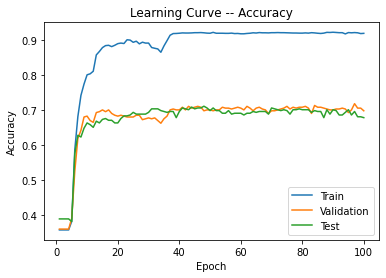

In [55]:
import matplotlib.pyplot as plt
plt.figure()
E = np.arange(1, max_epoch+1,1)
plt.title('Learning Curve -- Accuracy')
plt.plot(E, train_acc_stats, label='Train')
plt.plot(E, val_acc_stats, label='Validation')
plt.plot(E, test_acc_stats, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [56]:
class_train_acc, class_train_count = eval_classes(train_loader, net)
print('Accuracy of each class on Training set. hazardous wast:{:4f}\trecyclable waste:{:4f}\thousehold food waste:{:4f}\tresidual waste:{:4f}'.format(class_train_acc[0],class_train_acc[1],class_train_acc[2],class_train_acc[3]))
print('Amount of each class on Training set. hazardous wast:{}\trecyclable waste:{}\thousehold food waste:{}\tresidual waste:{}'.format(class_train_count[0],class_train_count[1],class_train_count[2],class_train_count[3]))
class_test_acc, class_test_count = eval_classes(test_loader, net)
print('Accuracy of each class on Test set. hazardous wast:{:4f}\trecyclable waste:{:4f}\thousehold food waste:{:4f}\tresidual waste:{:4f}'.format(class_test_acc[0],class_train_acc[1],class_test_acc[2],class_test_acc[3]))
print('Amount of each class on Test set. hazardous wast:{}\trecyclable waste:{}\thousehold food waste:{}\tresidual waste:{}'.format(class_test_count[0],class_test_count[1],class_test_count[2],class_test_count[3]))

Accuracy of each class on Training set. hazardous wast:0.992157	recyclable waste:0.000000	household food waste:0.988957	residual waste:0.964508
Amount of each class on Training set. hazardous wast:1020	recyclable waste:200	household food waste:815	residual waste:1127
Accuracy of each class on Test set. hazardous wast:0.772727	recyclable waste:0.000000	household food waste:0.789474	residual waste:0.610390
Amount of each class on Test set. hazardous wast:110	recyclable waste:19	household food waste:114	residual waste:154


In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        # self.alpha = alpha
        # if isinstance(alpha, (float, int, torch.long)): self.alpha = torch.Tensor([alpha, 1 - alpha])
        # if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())
        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [58]:
use_glove = True

net = CNN(100, len(complete_vocab), MAX_SEQ_LEN).to(device)
if use_glove:   
    net.embedding.weight.data.copy_(torch.from_numpy(np.array(wvecs)))
max_epoch = 100

optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

trainfocalgama = 0.5

train_acc_stats = []
val_acc_stats = []
test_acc_stats = []
train_loss_stats = []
val_loss_stats = []
test_loss_stats = []
best_test_acc = 0
print('Start training')
for epoch in range(max_epoch):
    net.train()
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input, target = batch
        input, target = input.to(device), target.to(device)
        # print(input.shape)
        pred = net(input).squeeze(1)
        loss = FocalLoss(gamma=trainfocalgama)(pred,target.long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * target.shape[0]
    net.eval()
    val_acc, val_loss = eval(val_loader, net)
    train_acc, train_loss = eval(train_loader, net)
    test_acc, test_loss = eval(test_loader, net)
    val_acc_stats.append(val_acc)
    val_loss_stats.append(val_loss)
    train_acc_stats.append(train_acc)
    train_loss_stats.append(train_loss)
    test_acc_stats.append(test_acc)
    test_loss_stats.append(test_loss)
    if test_acc > best_test_acc:
        best_test_acc = test_acc
    print('Epoch:{}\tTrain Loss:{:4f}\tTrain Acc:{:4f}\tVal Loss:{:4f}\tVal Acc:{:4f}\tTest Loss:{:4f}\tTest Acc:{:4f}\tBest Test Acc:{:4f}'.format(
        epoch+1, train_loss, train_acc, val_loss, val_acc,test_loss,test_acc,best_test_acc))


Start training


<ipython-input-57-2726ad9fa9af>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


Epoch:1	Train Loss:1.368580	Train Acc:0.322581	Val Loss:1.361292	Val Acc:0.343511	Test Loss:1.378855	Test Acc:0.277078	Best Test Acc:0.277078
Epoch:2	Train Loss:1.361390	Train Acc:0.322581	Val Loss:1.353981	Val Acc:0.343511	Test Loss:1.371851	Test Acc:0.277078	Best Test Acc:0.277078
Epoch:3	Train Loss:1.343113	Train Acc:0.343454	Val Loss:1.335351	Val Acc:0.346056	Test Loss:1.355470	Test Acc:0.312343	Best Test Acc:0.312343
Epoch:4	Train Loss:1.122766	Train Acc:0.497154	Val Loss:1.105729	Val Acc:0.493639	Test Loss:1.111368	Test Acc:0.528967	Best Test Acc:0.528967
Epoch:5	Train Loss:0.939052	Train Acc:0.641682	Val Loss:0.978737	Val Acc:0.600509	Test Loss:0.989261	Test Acc:0.594458	Best Test Acc:0.594458
Epoch:6	Train Loss:0.806624	Train Acc:0.707147	Val Loss:0.911027	Val Acc:0.628499	Test Loss:0.934464	Test Acc:0.614610	Best Test Acc:0.614610
Epoch:7	Train Loss:0.718596	Train Acc:0.749209	Val Loss:0.882021	Val Acc:0.648855	Test Loss:0.896915	Test Acc:0.637280	Best Test Acc:0.637280
Epoch:

In [59]:
net.eval()
test_acc, test_loss = eval(test_loader, net)
print('Test Acc:{}'.format(test_acc))

Test Acc:0.7002518891687658


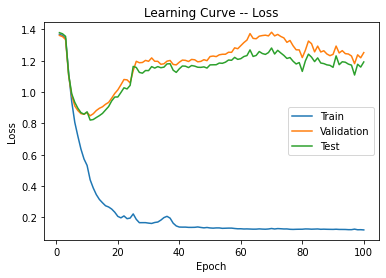

In [60]:
import matplotlib.pyplot as plt
plt.figure()
E = np.arange(1, max_epoch+1,1)
plt.title('Learning Curve -- Loss')
plt.plot(E, train_loss_stats, label='Train')
plt.plot(E, val_loss_stats, label='Validation')
plt.plot(E, test_loss_stats, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

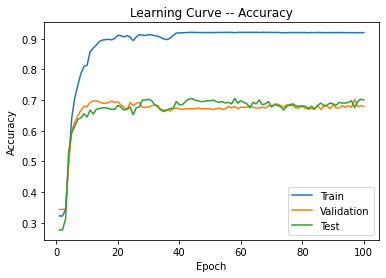

In [61]:
import matplotlib.pyplot as plt
plt.figure()
E = np.arange(1, max_epoch+1,1)
plt.title('Learning Curve -- Accuracy')
plt.plot(E, train_acc_stats, label='Train')
plt.plot(E, val_acc_stats, label='Validation')
plt.plot(E, test_acc_stats, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [62]:
class_train_acc, class_train_count = eval_classes(train_loader, net)
print('Accuracy of each class on Training set. hazardous wast:{:4f}\trecyclable waste:{:4f}\thousehold food waste:{:4f}\tresidual waste:{:4f}'.format(class_train_acc[0],class_train_acc[1],class_train_acc[2],class_train_acc[3]))
print('Amount of each class on Training set. hazardous wast:{}\trecyclable waste:{}\thousehold food waste:{}\tresidual waste:{}'.format(class_train_count[0],class_train_count[1],class_train_count[2],class_train_count[3]))
class_test_acc, class_test_count = eval_classes(test_loader, net)
print('Accuracy of each class on Test set. hazardous wast:{:4f}\trecyclable waste:{:4f}\thousehold food waste:{:4f}\tresidual waste:{:4f}'.format(class_test_acc[0],class_train_acc[1],class_test_acc[2],class_test_acc[3]))
print('Amount of each class on Test set. hazardous wast:{}\trecyclable waste:{}\thousehold food waste:{}\tresidual waste:{}'.format(class_test_count[0],class_test_count[1],class_test_count[2],class_test_count[3]))

Accuracy of each class on Training set. hazardous wast:0.984314	recyclable waste:0.000000	household food waste:0.975460	residual waste:0.984028
Amount of each class on Training set. hazardous wast:1020	recyclable waste:200	household food waste:815	residual waste:1127
Accuracy of each class on Test set. hazardous wast:0.709091	recyclable waste:0.000000	household food waste:0.736842	residual waste:0.753247
Amount of each class on Test set. hazardous wast:110	recyclable waste:19	household food waste:114	residual waste:154
